# **Graded Challenge 7**

Name    : Ardianto<br>
Batch   : FTDS-RMT 024

---

X-tech adalah perusahaan baru yang bergerak di bidang cyber-security. Salah satu fitur yang akan ditawarkan kepada para pengguna adalah fitur pendeteksi email spam. Pada fitur tersebut, email-email yang masuk ke komputer pengguna namun tidak penting seperti fraud, pishing, promotion, dan lain lain harus bisa deteksi agar user tidak perlu melihat atau membacar jenis email tersebut. Dalam tahap pengembangan awal, developer membuat sebuah model deep learning tujuannya untuk mendeteksi apakah email yang masuk termasuk spam atau tidak. Dalam waktu kurang dari satu minggu, tim harus berhasil membuat model deep learning tersebut sebagai langkah awal.

*Problem Statement*
> Membuat sebuah model deeplearning dengan akurasi di atas 80% untuk mendeteksi unsur spam dalam sebuah text dalam waktu satu minggu

### **A. Import Library**

In [63]:
# pandas and Numpy
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns

#string and regex
import re
import string

# tensorflow
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

#nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# import os <-- digunakan dlam colab env

# collections for counter
from collections import Counter

# saving files
import joblib as joblib

# set display
pd.options.display.max_colwidth = 2000

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ardia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ardia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ardia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **B. Data Download and Loading**

In [45]:
# this is for colab env
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# !chmod 600 /content/kaggle.json
# !kaggle datasets download -d datatattle/email-classification-nlp
# !unzip /content/email-classification-nlp.zip

**Create DataFrame**

In [64]:
test = pd.read_csv("SMS_test.csv", encoding='latin-1')
train = pd.read_csv("SMS_train.csv", encoding='latin-1')
df = pd.concat([train, test], axis=0)
df.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,Non-Spam
2,3,"Pity, * was in mood for that. So...any other suggestions?",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",Spam


Dataset berisikan text atau isi dari sebuah pesan atau email serta label klasifikasi pesan terkait.

**Dataset Size**

In [65]:
row, column = df.shape
print(f"Terdapat {row} baris dan {column} kolom")

Terdapat 1082 baris dan 3 kolom


**Missing Value Checking**

In [66]:
df.isna().sum()

S. No.          0
Message_body    0
Label           0
dtype: int64

Tidak terdapat missing value pada data.

### **C. EDA**

Dalam tahap ini, akan lebih terfokus pada eksplorasi:
- Perbandingan jumlah antar kategori label
- Kosa kata Unique dalam data
- Intensitas kemunculan sebuah kata
- Anomaly Detection
- Stopwords Detection

##### 1. Perbandingan Jumlah Antar Kategori Label

Label
Non-Spam    884
Spam        198
Name: count, dtype: int64


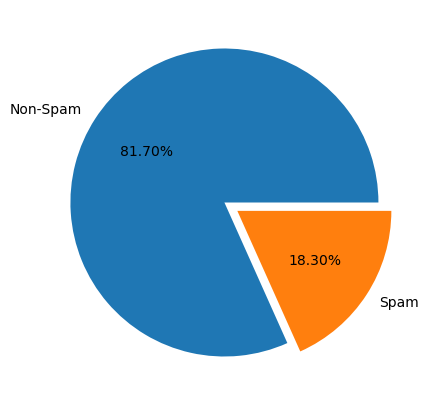

In [57]:
label_counts = df['Label'].value_counts()

fig = plt.figure(figsize=(9,5)) 
plt.pie(label_counts, autopct='%1.2f%%', labels=label_counts.index,explode=[0,0.1])
print(label_counts)
plt.show()

Jumlah antara label spam dan non-spam tergolong tidak seimbang dengan perbedaan yang dignifikan. Hal ini bisa menyebabkan lemahnya model dalam mengklasifikasikan kelas spam.

##### 2. Jumlah Kosa Kata Unique

In [67]:
def count_text(text):
  '''
  Fungsi ini menghitung setiap kata dalam dataframe
  '''
  text_list = text.str.split()

  # list untuk menampung semua kata dalam text dan title
  total_texts=[]

  # looping untuk setiap kata dalam text
  for content in text_list:
    for kata in content:
      total_texts.append(kata)
  total_texts = set(total_texts)
  return len(total_texts)

In [68]:
print("Total kata Unik di semua kelas: ",count_text(df['Message_body']))
print("Total kata Unik dalam kelas Non-Spam: ",count_text(df['Message_body'][df['Label']=='Non-Spam']))
print("Total kata Unik dalam kelas Spam: ",count_text(df['Message_body'][df['Label']=='Spam']))

Total kata Unik di semua kelas:  5523
Total kata Unik dalam kelas Non-Spam:  4046
Total kata Unik dalam kelas Spam:  1907


Jumlah kata unik dalam kelas spam lebih sedikit dibanding non-spam dikarenakan ketidakseimbangan data. Hal ini juga berpotensi mempengaruhi kinerja model terutama dalam menprediksikan kelas spam.

##### 3. Intensitas Kemunculan Kata

In [9]:
def count_occurence(text):

  '''
  fungsi ini menerima text dalam bentuk kalimat atau paragraf
  '''

  # menghapus spasi dan memisahkan setiap kata yang terpisah dengan spasi
  text_list = text.str.strip().str.split()

  # container list
  total_texts=[]

  # nested loop yang akhirnya masukan setiap kata pada total_texts
  for content in text_list:
    for kata in content:
      total_texts.append(kata)

  # stopwords
  stopwords_en = list(set(stopwords.words('english')))

  # list comprehension untuk setiap kata yang tidak ada pada stopwords
  rem_stopwords = [word for word in total_texts if word not in stopwords_en]

  # mengembalikan hasil dengan Counter dari collections
  return Counter(rem_stopwords)

In [10]:
# panggil fungsi di atas dengan memasukan series
word_count = count_occurence(df['Message_body'])

# panggil fungsi dengan filter
non = count_occurence(df['Message_body'][df['Label']=='Non-Spam'])
spam = count_occurence(df['Message_body'][df['Label']=='Spam'])

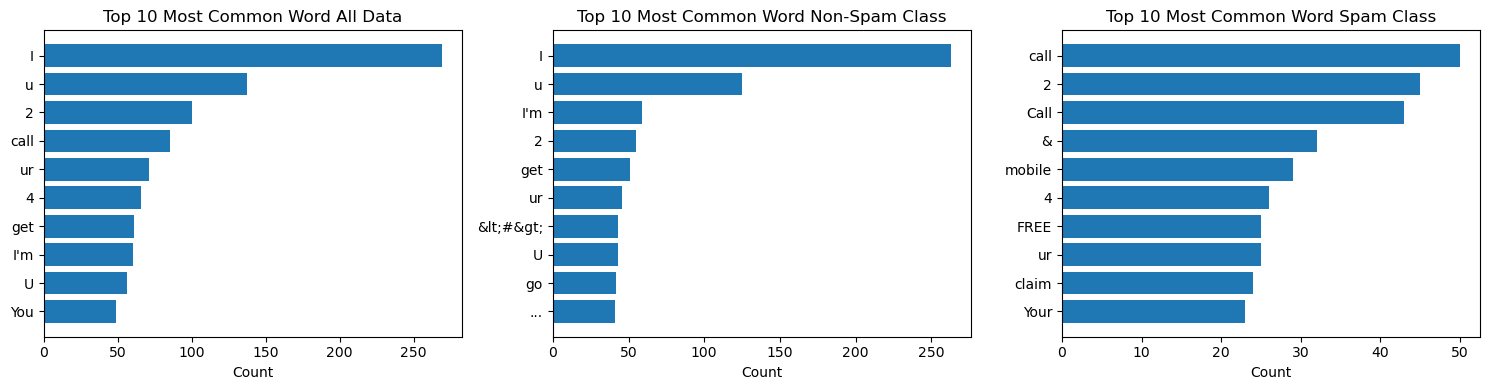

In [11]:
# karena hasil fungsi berupa object Counter maka bisa gunakan most_common dan slice 10 value teratas
sorted_all = word_count.most_common()[:10]
sorted_non = non.most_common()[:10]
sorted_spam = spam.most_common()[:10]

# list hasil most_common di atas
list_sorted = [sorted_all, sorted_non, sorted_spam]

# list label
name = ['All Data', 'Non-Spam Class', 'Spam Class']

# visualisasi
figure = plt.figure(figsize=(15,4))
for i, sorted in enumerate(list_sorted):
  labels, values = zip(*sorted)
  plt.subplot(1,3,i+1)
  # plot data
  plt.barh(labels, values)
  plt.xlabel('Count')
  plt.title(f'Top 10 Most Common Word {name[i]}')
  plt.gca().invert_yaxis()
plt.tight_layout()

Dari chart di atas:
- Masih terdapat karakter-karakter yang tidak dibutuhkan seperit dilihat pada chart seperti symbol atau angka. 
- Kata seperti Call, Free, termasuk kata yang paling sering muncul pada Spam class. Pada non spam, terlihat kata-kata seperti i, u, i'm yang lebih sering muncul. Kata kata tersebut lebih umum ditemukan pada percakapan casual.

##### 4. Anomaly Detection

Bagian ini akan mendeteksi karakter-karakter spesial yang bukan termasuk a-z atau A-Z. Hal ini termasuk mencari punctuation dan karakter-karakter lain.

In [69]:
def characters(text):
    '''
    fungsi ini menerima text
    '''
    # hapus spasi dan pisahkan setiap kata
    text_list = text.str.strip().str.split()

    # list character a-z dan A-Z dari string
    string_list = list(string.ascii_letters)

    # containers karakter
    char_list = []

    # nested loop yang memasukan setiap karakter dalam data
    for text in text_list:
        for word in text:
            for char in word:
                # jika karakter tidak ada pada string_list
                if char not in string_list:
                    char_list.append(char)
    
    # ubah menjadi set untuk memfilter menjadi unique value
    char_set = set(char_list)

    # kembalikan set menjadi lis
    result = list(char_set)
    return result


In [70]:
unique_char_anomaly = characters(df['Message_body']) # panggil fungsi di atas

# print jumlah karakter unik
print(len(unique_char_anomaly))

# for loop untuk print setiap karakter dipisahkan dengan koma
for item in unique_char_anomaly:
    print(f"{item},",end=' ')

47
, =, *, Ü, , ;, !, ì, 1, 0, <, ?, @, 8, ], ', :, #, ., >, 4, , (, [, |, 9, 2, ú, 3, +, $, 7, &, é, ¡, ,, %, 5, 6, £, -, É, /, ), _, ü, ", 

Dari hasil di atas, kita bisa melihat bahwa terdapat 47 unique karakter seperti symbol, angka dan lain sebagainya yang bukan termasuk karakter biasa dari a-z atau A-Z.
> Karakter karakter tersebut akan dihilangkan dari data.

##### 5. Stopwords Detections

Dalam Natural Language Processing atau NLP, "stopwords" merujuk pada kata-kata yang umumnya dianggap tidak memiliki makna khusus dan sering diabaikan atau dihapus dari teks. Kata-kata ini umumnya adalah kata hubung, kata depan, atau kata umum lainnya yang muncul secara sering dalam bahasa yang tidak memberikan kontribusi signifikan terhadap makna suatu teks.

Contoh stopwords dalam bahasa Inggris meliputi kata-kata seperti "the", "and", "is", "in", dan sebagainya. Dalam pemrosesan teks, penghapusan stopwords umum dilakukan untuk membersihkan teks dan meningkatkan efisiensi analisis, karena kata-kata ini dianggap tidak membawa banyak informasi penting.

In [71]:
def find_stopwords(text):
    '''
    fungsi ini menerima text untuk diperiksa apakah sama dengan yang ada di stopwords
    '''
    # hapus spasi dan pisahkan setiap kata
    text_list = text.str.strip().str.split()

    # list stopwords
    stopwords_en = list(set(stopwords.words('english')))

    # tampungan stopwords yang ada pada data
    stop = []

    # for loop untuk memasukan kata yang sama dengan yang ada pada list stopwords
    for text in text_list:
        for word in text:
            if word in stopwords_en:
                stop.append(word)
    return stop

In [72]:
stop_w = find_stopwords(df['Message_body']) # panggil fungsi

# print hasil
print(f"Terdapat sebanyak {len(stop_w)} atau sebanyak {len(set(stop_w))} kata stopwords unik pada data ")

Terdapat sebanyak 4886 atau sebanyak 134 kata stopwords unik pada data 


Stopwords ditemukan pada data, kata-kata tersebut akan dihilangkan dari data untuk kerperluan pemodelan yang lebih efisien.

##### 6. Check Duplikat Data

In [16]:
df.duplicated().sum() # untuk mencari jumlah duplikat data

0

Tidak terdapat beberapa row yang terduplikasi.

### **D. Data Preprocessing**

Pada bagian ini dilakukan beberapa proses seperti:
1. Data Cleaning
    - Mengubah setiap kata menjadi lowercase
    - Menghapus mention seperti @xxx
    - Menghapus new line atau ganti baris
    - Menghapus spasi di awal dengan akhir
    - Menghapus Url http: atau www.
    - Menghapus karakter-karakter spesial
    - Menghapus stopwords termasuk kata yang mengandung apostrophe seperti you're, would've dll.
    - Tokenisasi dan Lemmatization
2. EDA Setelah Data Cleaning
3. Data Split
4. Vectorization dan Embedding

##### **1. Data Cleaning**

In [73]:
lemmatizer = WordNetLemmatizer() # lematizer
stopwords_en = list(set(stopwords.words('english'))) # stopwords

In [74]:
def text_preprocessing(text):
  '''
  Fungsi ini mengambil baris perbaris texts yang setiap text akan diproses berdasarkan gambaran di atas.
  '''

  # lowercasing text
  text = text.lower()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # menghapus mention
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # menghapus hastag
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # menghapus new line atau ganti baris
  text = re.sub(r"\\n", " ",text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", "", text)

  # Whitespace removal
  text = text.strip()

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stopwords_en]

  # menghapus kata dengan .com
  tokens = [word for word in tokens if 'com' not in word]

  # menghapus apphostrophe (ditemukan pada beberapa data)
  tokens = [word for word in tokens if "'" not in word]

  # Lemmatize
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Stopwords removal part 2 karena setelah lematize, bisa memunculkan kata baru yang berupa stopwords
  tokens = [word for word in tokens if word not in stopwords_en]

  # removing only 2 character word
  tokens = [word for word in tokens if len(word)>2]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [75]:
# menerapkan fungsi di atas pada setiap baris kolom Message_body
df['cleaned'] = df['Message_body'].apply(lambda x: text_preprocessing(x))
df.sample(2)

,S. No.,Message_body,Label,cleaned
412,413,"Sir, I need Velusamy sir's date of birth and company bank facilities details.",Non-Spam,sir need velusamy sir date birth bank facility detail
143,144,Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.,Spam,santa calling would little one like call santa xmas eve call book time


Terlihat dari sample data, karakter-karakter dan kata yang tidak diperlukan berhasil dihilangkan.

##### **2. EDA After Cleaning**

Jumlah Kosa Kata Unik

In [20]:
# memanggil fungsi countext
all_before = count_text(df['Message_body']) 
# memanggil fungsi countext dengan filter Label
non_before = count_text(df['Message_body'][df['Label']=='Non-Spam'])
spam_before = count_text(df['Message_body'][df['Label']=='Spam'])

# memanggil fungsi countext untuk hasil cleaning
all_after = count_text(df['cleaned'])
# memanggil fungsi countext dengan filter
non_after = count_text(df['cleaned'][df['Label']=='Non-Spam'])
spam_after = count_text(df['cleaned'][df['Label']=='Spam'])

# print variables di atas
print(f"Total kata Unik di semua kelas: {all_before}")
print(f"Total kata Unik dalam kelas Non-Spam: {non_after}")
print(f"Total kata Unik dalam kelas Spam: {spam_after}")

# print data setelah clearning dengan tambahan menghitung persentase data yang berkurang
print("\nafter pre-processing")
print(f"Total kata Unik di semua kelas: {all_after}, berkurang {(all_before-all_after)/all_before*100:.2f}%")
print(f"Total kata Unik dalam kelas Non-Spam: {non_after}, berkurang {(non_before-non_after)/non_before*100:.2f}%")
print(f"Total kata Unik dalam kelas Spam: {spam_after}, berkurang {(spam_before-spam_after)/spam_before*100:.2f}%")

Total kata Unik di semua kelas: 5523
Total kata Unik dalam kelas Non-Spam: 2275
Total kata Unik dalam kelas Spam: 833

after pre-processing
Total kata Unik di semua kelas: 2826, berkurang 48.83%
Total kata Unik dalam kelas Non-Spam: 2275, berkurang 43.77%
Total kata Unik dalam kelas Spam: 833, berkurang 56.32%


Jumlah kata unik dalam data telah berkurang secara signifikan untuk setiap kelas. Dengan berkurangnya data, proses training model akan jauh lebih efisien.

Top 10 Most Common Word

In [22]:
word_count = count_occurence(df['cleaned']) # panggil kembali fungsi count_occurence

# terapkan filter untuk setiap kelas
non = count_occurence(df['cleaned'][df['Label']=='Non-Spam'])
spam = count_occurence(df['cleaned'][df['Label']=='Spam'])

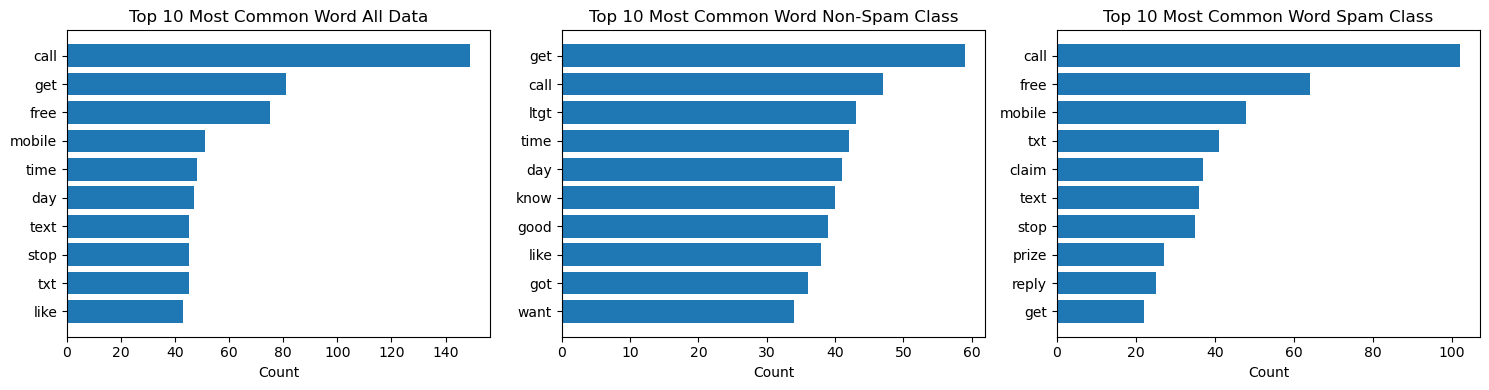

In [23]:
# gunakan most_common dari attribute counter object
sorted_all = word_count.most_common()[:10]
sorted_non = non.most_common()[:10]
sorted_spam = spam.most_common()[:10]

# masukan variable ke dalam list
list_sorted = [sorted_all, sorted_non, sorted_spam]

# masukan list label 
name = ['All Data', 'Non-Spam Class', 'Spam Class']

# visualisasi
figure = plt.figure(figsize=(15,4))
for i, sorted in enumerate(list_sorted):
  labels, values = zip(*sorted)
  plt.subplot(1,3,i+1)
  # plot data
  plt.barh(labels, values)
  plt.xlabel('Count')
  plt.title(f'Top 10 Most Common Word {name[i]}')
  plt.gca().invert_yaxis()
plt.tight_layout()

Jika dibandingkan dengan top 10 most common word pada EDA awal, terlihat adanya perbedaan pada top list setiap kategori. Pada spam class terlihat kata yang mendominasi adalah call, free, txt, claim dan lain-lain. Kata-kata tersebut bisa menjadi alasan paling berpengaruh kenapa sebuah email bisa dikategorikan sebagai spam.

Anomaly and Stopwords Detection

In [24]:
unique_char_anomaly = characters(df['cleaned']) # panggil kembali fungsi characters

#print unique value
print(len(unique_char_anomaly))

# cek stop words dan print hasil
stop_w = find_stopwords(df['cleaned'])
print(f"Terdapat sebanyak {len(stop_w)} atau sebanyak {len(set(stop_w))} kata stopwords unik pada data ")

0
Terdapat sebanyak 0 atau sebanyak 0 kata stopwords unik pada data 


- Terlihat sudah tidak ada karakter-karakter non-letter pada data yang sudah dibersihkan.
- Tidak terdapat stopwords pada text.

##### **3. Data Split**

Dikarenakan vektorisasi dilakukan setelah data splitting, label diubah terlebih dahulu ke dalam binary value 0 dan 1 sebelum data splitting.

In [25]:
df['target'] = df['Label'].replace({'Non-Spam' : 0, 'Spam' : 1}) # mengubah vale 0 menjadi Non-spam dan 1 menjadi spam
df[['Label','target']].head()

,Label,target
0,Non-Spam,0
1,Non-Spam,0
2,Non-Spam,0
3,Non-Spam,0
4,Spam,1


Splitting Data

In [26]:

# split data train dan test validation
X_train_val, X_test, y_train_val, y_test = train_test_split(df.cleaned,
                                                    df.target,
                                                    test_size=0.35,
                                                    random_state=20,
                                                    stratify=df.target)

# Split data train dan test validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.3,
                                                  random_state=20,
                                                  stratify=y_train_val)

# print jumlah
print('Train Size : ', X_train.shape[0])
print('Val Size   : ', X_val.shape[0])
print('Test Size  : ', X_test.shape[0])

Train Size :  492
Val Size   :  211
Test Size  :  379


##### **4. Text Vectorization and Embedding**

In [27]:
Vectorize = CountVectorizer() # countvectorizer

# fit dan transform
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_train_vec

<492x1704 sparse matrix of type '<class 'numpy.int64'>'
	with 3730 stored elements in Compressed Sparse Row format>

In [28]:
# mengambil jumlah vocabulary
total_vocab = len(Vectorize.vocabulary_.keys())

# mengambil jumlah kata terbanyak dalam satu kalimat
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  1704
Maximum Sentence Length :  30 tokens


In [29]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

# adapt vecotrization terhadap X_train
text_vectorization.adapt(X_train)

In [30]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

### **E. Model Definition, Training and Evaluation**

##### 1. Model 1

Model 1 ini menggunakan kombinasi Bidirectional LSTM (Long Short Term Memory) yang terdiri dari:
1. Vektorisasi Teks atau Proses mengubah teks menjadi representasi angka, dan proses tokenisasi yang terdapat didalamnya.
2. Layer embedding
3. Dua layer LSTM (Long Short-Term Memory) yang bersifat bidirectional. LSTM digunakan untuk menangkap pola sekuensial atau urutan dan hubungan jangka panjang dalam teks.
4. Dense layer berupa satu ouput the activation sigmoid.

In [32]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm = Sequential()
model_lstm.add(text_vectorization)
model_lstm.add(embedding)
model_lstm.add(Bidirectional(LSTM(32,return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(16,kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()
model_lstm_hist = model_lstm.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 64)            109056    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                        

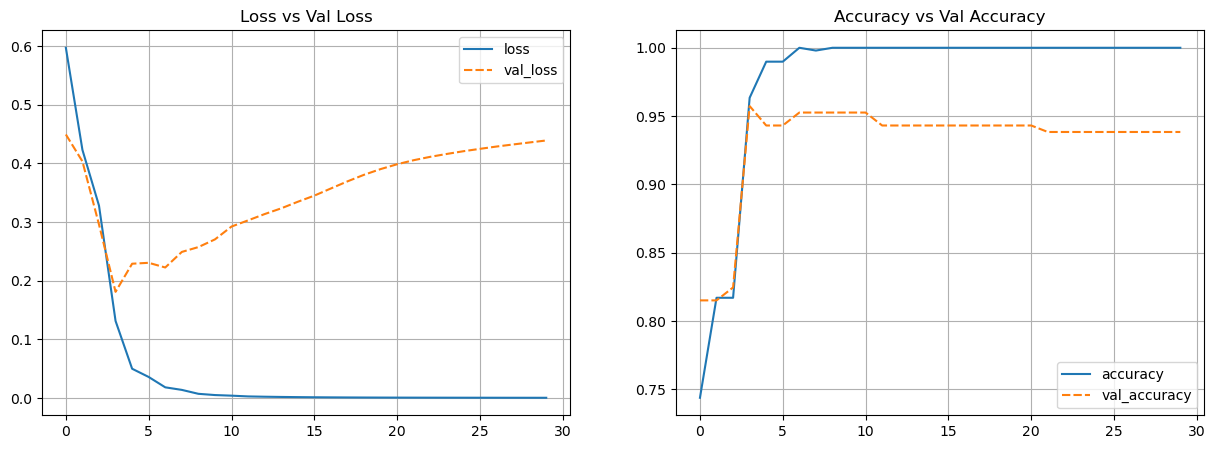

In [33]:
# plotting loss dan loss val serta accuracy 
history_df = pd.DataFrame(model_lstm_hist.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df[['loss','val_loss']])
plt.grid(True)
plt.title("Loss vs Val Loss")

plt.subplot(1,2,2)
sns.lineplot(data=history_df[['accuracy','val_accuracy']])
plt.grid(True)
plt.title("Accuracy vs Val Accuracy")
plt.show()

Terlihat pada hasil graph:
- Validation loss cenderung mengalami kenaikan setelah melalui epoch 20 dan terdapat perbedaan yang cukup signifikan antara loss dan validation loss yang menandakan model cenderung mengalami overfit.
- Pada chart accuracy, kedua nilai accuracy berjalan sejajar setelah epoch 14 atau 15 dengan gap sekitar 0.05. Ini menandakan adanya masalah kinerja generalisasi model.

##### 2. Model 2 - Improvement
Model improvement ini memodifikasi model 1 dimana dropout ditambahkan untuk setiap bidirectional LSTM layer, dan ditambahkan juga regularisasi l2 atau Ridge Regression. Pada model ini juga diterapkan callback yaitu early stopping dengan patience 5 yang berarti training akan berhenti setelah mengalami 5 epoch tanpa improvement lalu model akan mengembalikan weights terbaik.

In [34]:

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
## Define the architecture
model_imv = Sequential()
model_imv.add(text_vectorization)
model_imv.add(embedding)
model_imv.add(Bidirectional(LSTM(16,return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.L2(0.01))))
model_imv.add(Dropout(0.3))
model_imv.add(Bidirectional(LSTM(8,kernel_initializer=tf.keras.initializers.GlorotUniform(seed),kernel_regularizer=tf.keras.regularizers.L2(0.01))))
model_imv.add(Dropout(0.3))
model_imv.add(Dense(1, activation='sigmoid'))


model_imv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_imv.summary()
model_imv_hist = model_imv.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),callbacks=[early_stopping_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 64)            109056    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 32)           10368     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                        

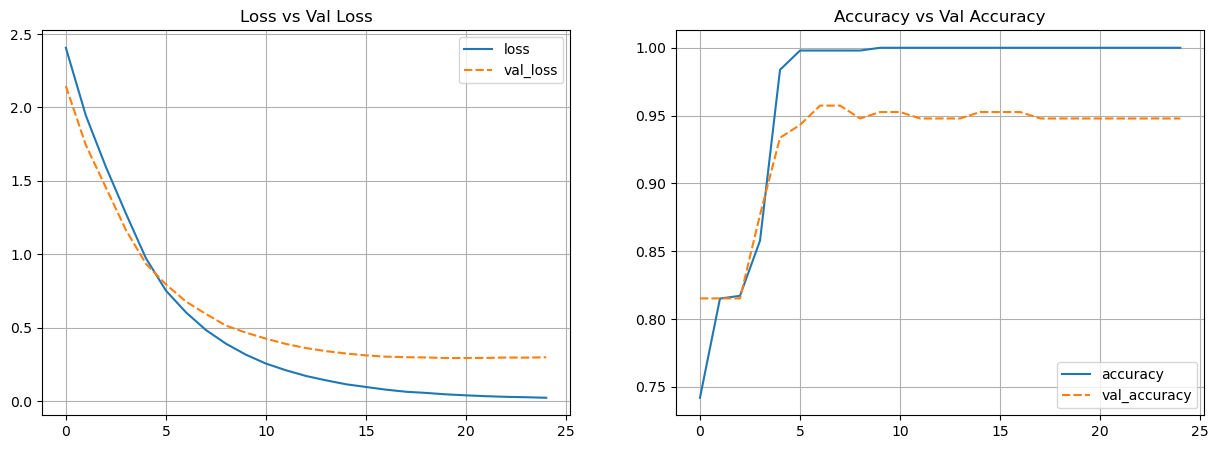

In [35]:
history_df = pd.DataFrame(model_imv_hist.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df[['loss','val_loss']])
plt.grid(True)
plt.title("Loss vs Val Loss")

plt.subplot(1,2,2)
sns.lineplot(data=history_df[['accuracy','val_accuracy']])
plt.grid(True)
plt.title("Accuracy vs Val Accuracy")
plt.show()

Dari hasil model 2, bisa dilihat bahwa:
1. Nilai loss vs val loss menunjukan arah yang sama seiring dengan bertambahnya epoch. Nilai loss yang semakin menurun menunjukan bahwa mesin belajar mengurangi kesalan secara bertahap. Model hampir menunjukan konvergensi andai saja perbedaan tidak terlalu besar.
2. Pada chart accuracy, hasil model kedua ini serupa dengan model pertama. Dimana nilai cukup sejajar dan terdapat gap yang konstan di antara kedua nilai accuracy.
3. Masih terdapat adanya indikasi overfitting. Meskipun begitu, model menunjukan perbaikan dibanding model pertama.

##### 3. Transfer Learning

Dibagian transfer learning, pre-trained model yang digunakan adalah Neural-Net Language Models (dari Google) variasi english dengan 128 dimensi. Tujuan utama NNLM adalah memahami hubungan antar kata dan menghasilkan representasi vektor kata yang menyimpan informasi tentang struktur dan arti kata-kata tersebut.

In [36]:
# url NNLM
url = 'https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/tf2-preview-en-dim128-with-normalization/versions/1'
# definisi hub_layer
hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [37]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_tf = Sequential()
model_tf.add(hub_layer)
model_tf.add(Reshape((128,1)))
# model_tf.add(text_vectorization)
model_tf.add(Bidirectional(LSTM(16,return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_tf.add(Dropout(0.1))
model_tf.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_tf.add(Dropout(0.1))
model_tf.add(Dense(1, activation='sigmoid'))

# compile and summary
model_tf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_tf.summary()

# fit in history
model_tf_hist = model_tf.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128, 32)          2304      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 32)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

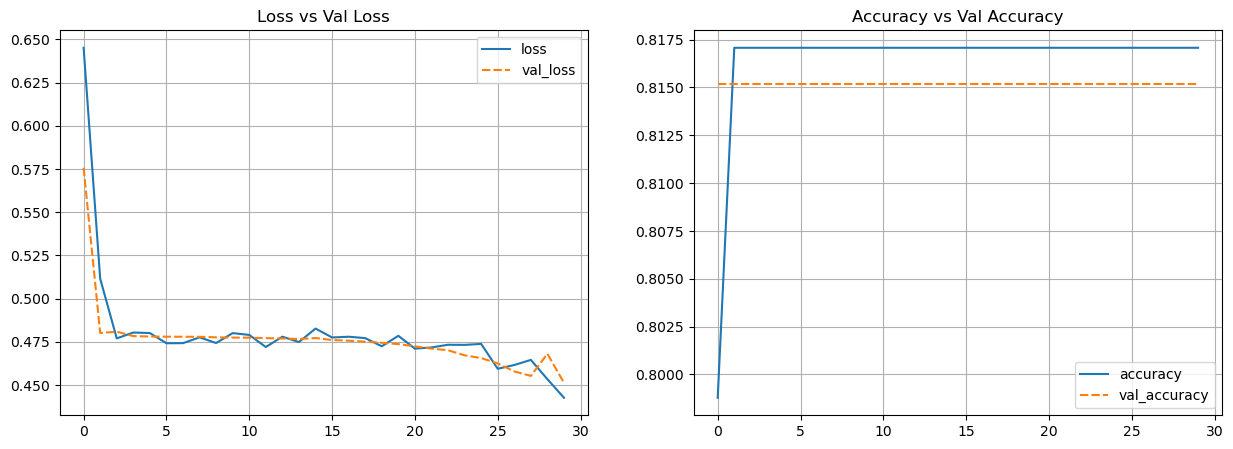

In [38]:
history_df = pd.DataFrame(model_tf_hist.history)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df[['loss','val_loss']])
plt.grid(True)
plt.title("Loss vs Val Loss")

plt.subplot(1,2,2)
sns.lineplot(data=history_df[['accuracy','val_accuracy']])
plt.grid(True)
plt.title("Accuracy vs Val Accuracy")
plt.show()

- Nilai loss dan val loss tidak memiliki perbedaan yang terlalu siginifikan. 
- Nilai accuracy juga menujukan adanya pola yang konstan. Accuracy dan validation accuaracy sama-sama bergerak dengan arah yang sama dengan nilai yang tidak jauh berbeda. Hail ini bisa mengindikasikan adanya masalah generalisasi pada model. 
- Masih belum bisa dipastikan apakah model transfer learning ini lebih baik dari kedua model pertama. 

##### 4. Model Predictions and Evaluation

**Model LSTM 1**

In [40]:
y_train_pred_lstm = model_lstm.predict(X_train)
y_train_pred_lstm = np.where(y_train_pred_lstm >= 0.5, 1, 0)

y_test_pred_lstm = model_lstm.predict(X_test)
y_test_pred_lstm = np.where(y_test_pred_lstm >= 0.5, 1, 0)


print("Train Data:")
print(classification_report(y_train, y_train_pred_lstm))
print("Test Data:")
print(classification_report(y_test, y_test_pred_lstm))

12/12 [==============================] - 0s 15ms/step
Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       0.98      1.00      0.99        90

    accuracy                           1.00       492
   macro avg       0.99      1.00      0.99       492
weighted avg       1.00      1.00      1.00       492

Test Data:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       310
           1       0.79      0.67      0.72        69

    accuracy                           0.91       379
   macro avg       0.86      0.81      0.83       379
weighted avg       0.90      0.91      0.90       379



- Model pertama LSTM memiliki performa yang overfit, dimana model sangat baik dalam memprediksi data train namun mengalami penurunan perfromansi pada data test. Hal ini ditandai dengan nilai nilai yang ada metric untuk data train yang sempurna atau memiliki nilai 1 pada setiap metrik.
- Pada test data, metrik yang didapat oleh model pertama ini memiliki nilai yang berbeda-beda. Model secara lebih baik dapat mengidentifikasi class 0 dibanding class 1. Hal ini dipengaruhi kondisi yang tidak seimbang antara jumlah class 0 dan 1.

**Model LSTM 2**

In [41]:
y_train_pred_imp = model_imv.predict(X_train)
y_train_pred_imp = np.where(y_train_pred_imp >= 0.5, 1, 0)


y_test_pred_imp = model_imv.predict(X_test)
y_test_pred_imp = np.where(y_test_pred_imp >= 0.5, 1, 0)


print('Train Data:')
print(classification_report(y_train, y_train_pred_imp))
print("Test Data:")
print(classification_report(y_test, y_test_pred_imp))

12/12 [==============================] - 0s 11ms/step
Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00        90

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492

Test Data:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       310
           1       0.98      0.64      0.77        69

    accuracy                           0.93       379
   macro avg       0.95      0.82      0.87       379
weighted avg       0.93      0.93      0.93       379



- Model kedua LSTM ini menunjukan hasil yang mirip dengan model pertaman dimana model sangat baik dalam memprediksi data train namun mengalami penurunan perfromansi pada data test.
- Model kedua dari LSTM ini menunjukan kinerja yang sedikit lebih baik dibanding dengan model pertama ditandai dengan f1 score dan precision yang lebih tinggi terutama untuk class 1. Artinya, model kedua ini lebih baik dalam mengidentifikasi kelas 1 atau spam dibanding model pertama.

**Model Transfer Learning**

In [42]:
y_train_pred_tf = model_tf.predict(X_train)
y_train_pred_tf = np.where(y_train_pred_tf > 0.5, 1, 0)

y_test_pred_tf = model_tf.predict(X_test)
y_test_pred_tf = np.where(y_test_pred_tf > 0.5, 1, 0)

# Print classification report
print('Train Data:')
print(classification_report(y_train, y_train_pred_tf))

print('Test Data:')
print(classification_report(y_test, y_test_pred_tf))

12/12 [==============================] - 0s 31ms/step
Train Data:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       402
           1       0.00      0.00      0.00        90

    accuracy                           0.82       492
   macro avg       0.41      0.50      0.45       492
weighted avg       0.67      0.82      0.73       492

Test Data:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       310
           1       0.00      0.00      0.00        69

    accuracy                           0.82       379
   macro avg       0.41      0.50      0.45       379
weighted avg       0.67      0.82      0.74       379



c:\Users\ardia\Miniconda3\envs\hacktiv8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardia\Miniconda3\envs\hacktiv8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ardia\Miniconda3\envs\hacktiv8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\a

- Model dengan transfer learning menunjukan ketidakmampuan dalam mengidentifikasi spam atau class 1 baik dalam train ataupun test data ditandai dengan score setiap metrik 0 untuk kelas 1 baik pada train ataupun test data. 
- Terdapat nilai yang identik antara train data dan test data terutama pada semua metrik. Hal ini mengindikasikan bahwa model memiliki masalah dalam generalisasi yang bisa disebabkan oleh bebrapa faktor yang mungkin seperti dataset yang kurang terutama untuk class 1 ataupun arsitektur model di dalamnya. Perlu diadakan pengembangan lebih lanjut untuk mencari akar masalah pada model ini. 

**Kesimpulan Evaluasi**

- Model pertama dan kedua memiliki kecenderungan lebih baik pada train data. Namun model kedua hasil improovement dengan adanya regularisasi, dropout, dan jumlah neuron yang diperkecil mampu meningkatkan kinerja klasifikasi spam pada data test meskipun tidak terlalu signifikan.
- Model transfer learning memiliki kemampuan yang buruk dalam mengidentifikasi spam dibanding dengan model 1 dan 2. Hal ini bisa disebabkan oleh tidak diterapkannya layer text vectorization dari dataset asli, kurangnya data, atau tidak seimbangnya jumlah atar label atau kelas.
- Dengan adanya poin di atas, model kedua hasil improvement dengan Bidirectional LSTM yang ditambah dropout dan regularisasi L2 akan digunakan untuk model saving dan deployment.

### **F. Model Saving**

Freezing Model

In [43]:
model_imv.trainable=False
model_imv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 64)            109056    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 32)           10368     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                        

Saving Model

In [51]:
model_imv.save('deployment/spam_identifier_savedmodel', save_format='tf')

INFO:tensorflow:Assets written to: deployment/spam_identifier_savedmodel\assets


INFO:tensorflow:Assets written to: deployment/spam_identifier_savedmodel\assets


In [55]:
# untuk eda deployment
df.to_csv('deployment/data_eda.csv')

### **G. Model Inference**
Pada notebook inference

### **H. Conclusion**

**Business Domain**<br>
Model Deep learning berhasil dibuat dengan waktu kurang dari satu minggu dengan kemampuan model yang cukup baik dalam mengidentifikasi apakah email termasuk ke dalam spam atau tidak. Meskipun tim berhasil membuat model dalam waktu kurang dari satu minggu, hasil yang diperoleh masih harus diperbaiki. 

**Model:**<br>
Terdapat perbaikan performa pada model improvement kedua. Model ini dirancang dengan menggabungkan arsitektur bidirectional LSTM, yang ditambahkan dengan Dropout layer dan Regularisasi L2. Dari hasil pengujian tiga model yang dibuat, model kedua dengan bidirectional LSTM ini menunjukkan kinerja yang lebih baik pada data dengan dibandingkan dengan dua model lainnya. Model menunjukkan kinerja yang sangat baik pada data Train dan baik pada data Test, namun nilai recall untuk kelas 1 pada data test menunjukkan perlunya perbaikan, terutama dalam mengidentifikasi text yang seharusnya termasuk dalam kelas spam. Kemungkinan terbesar penyebab masalah ini adalah kondisi kelas yang tidak seimbang pada dataset. 

**Further-Development:**
- Direkomendasikan untuk melakukan eksplorasi lebih terkait jumlah layer dan neuron atau hyperparameter lain dengan trial and error. 
- Model bisa ditrain ulang menggunakan dataset yang lebih seimbang dan perlu dibandingkan hasil nya.
- Pengembangan selanjutnya bisa terfokus pada recall kelas 1 pada model kedua yang memiliki kecenderungan untuk salah memprediksi true positive Mungkin bisa dilakukan dengan menyesuaikan threshold prediksi atau menggunakan metode lainnya.
